In [3]:
!pip install pmaw

In [1]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as SIA
from spacy.util import minibatch, compounding
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pmaw import PushshiftAPI
from spacy.tokens import Span
from nltk.util import ngrams
import more_itertools as mit
import plotly.express as px
from scipy import stats
import yfinance as yf
import datetime as dt
import seaborn as sns
import pandas as pd
import collections
import numpy as np
import operator
import spacy
import nltk
import re
import os

sns.set_style('darkgrid')
nlp = spacy.load("en_core_web_sm")
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Saim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
## used to solve the problem of importing spacy model en_core_web_sm.load() and nltk
# pip install nltk
# pip install spacy==2.3.5
# pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.1/en_core_web_sm-2.3.1.tar.gz
# !pip install pyresparser

In [2]:
api = PushshiftAPI()

# Convert dates to epoch time format
before = int(dt.datetime(2021,5,1,0,0).timestamp())
after = int(dt.datetime(2021,1,1,0,0).timestamp())

subreddit = "wallstreetbets"
limit = 500000

comments = api.search_comments(subreddit = subreddit,
                                           limit = limit,
                                           before = before,
                                           after = after)

print(f'Retrieved {len(comments)} comments from Pushshift')

Total:: Success Rate: 97.39% - Requests: 5164 - Batches: 517 - Items Remaining: 0
Retrieved 500000 comments from Pushshift


In [3]:
df = pd.DataFrame(comments)
print(df.shape)
df.head()

(500000, 38)


,all_awardings,associated_award,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,author_flair_type,...,send_replies,stickied,subreddit,subreddit_id,top_awarded_type,total_awards_received,treatment_tags,author_cakeday,distinguished,media_metadata
0,[],None,JimmyChill2020,#ffffff,None,"[{'e': 'text', 't': 'big gulps huh?'}]",acf21f8a-b20b-11e8-8717-0ee9cf2d415a,big gulps huh?,dark,richtext,...,True,False,wallstreetbets,t5_2th52,None,0,[],NaN,NaN,NaN
1,[],None,PlaneIntroduction8,,None,"[{'e': 'text', 't': '210112:1:2:ANAL GoD'}]",None,210112:1:2:ANAL GoD,dark,richtext,...,True,False,wallstreetbets,t5_2th52,None,0,[],NaN,NaN,NaN
2,[],None,funkychunkystuff,None,None,[],None,None,None,text,...,True,False,wallstreetbets,t5_2th52,None,0,[],NaN,NaN,NaN
3,[],None,Hawkinthearena,None,None,[],None,None,None,text,...,True,False,wallstreetbets,t5_2th52,None,0,[],NaN,NaN,NaN
4,[],None,GoBeaversOSU,,None,"[{'e': 'text', 't': '🦆 Duck Cunt Champ🦆'}]",None,🦆 Duck Cunt Champ🦆,dark,richtext,...,True,False,wallstreetbets,t5_2th52,None,0,[],NaN,NaN,NaN


In [4]:
#Dropping unneccesary columns and nan's
def drop(dataframe):
    dataframe.drop(['all_awardings', 
                    'associated_award',
                    'author_flair_background_color', 
                    'author_flair_css_class', 
                    'author_flair_richtext', 
                    'author_flair_template_id', 
                    'author_flair_text', 
                    'author_flair_text_color', 
                    'author_flair_type', 
                    'author_fullname', 
                    'author_patreon_flair', 
                    'author_premium', 
                    'awarders', 
                    'collapsed_because_crowd_control', 
                    'comment_type', 
                    'gildings', 
                    'link_id', 
                    'locked', 
                    'no_follow', 
                    'send_replies', 
                    'top_awarded_type', 
                    'total_awards_received', 
                    'treatment_tags', 
                    'distinguished', 
                    'author_cakeday', 
                    'is_submitter', 
                    'parent_id', 
                    'permalink', 
                    'retrieved_on',
                    'stickied', 
                    'subreddit_id',
                    'subreddit',
                    'media_metadata', 
                    'score'], 
                   axis=1, 
                   inplace = True)
    
    df.dropna(inplace = True)
    
    return dataframe

df = drop(df)
df.head()

,author,body,created_utc,id
0,JimmyChill2020,United States of Aaple,1610492039,gj1vrqg
1,PlaneIntroduction8,First of all since when did the verge actually...,1610492039,gj1vrqa
2,funkychunkystuff,Yeah except that if the shareholders or people...,1610492037,gj1vrkj
3,Hawkinthearena,Nobody cares where you got the money you put i...,1610492037,gj1vrjj
4,GoBeaversOSU,SINK for now,1610492036,gj1vril


In [5]:
# Converting epoch time to datetime, cast as date, then sort by new "Date" column
def date_cast(dataframe):
    dataframe['Date'] = dataframe['created_utc'].apply(lambda x: dt.datetime.fromtimestamp(int(x)).strftime('%Y-%m-%d'))
    dataframe['Date'] = dataframe['Date'].astype('datetime64')
    dataframe.sort_values(by ='Date', inplace=True)
    
    print(dataframe['Date'].dtypes)
    return dataframe

df = date_cast(df)
df.head()

datetime64[ns]


,author,body,created_utc,id,Date
467541,beefywhip,"I’m sorry to tell you this, but you have a con...",1609525194,ghqp94w,2021-01-01
465990,Aktin,same I got my masters in 2019. I thought 2020...,1609480758,ghoix2r,2021-01-01
465989,Hubers57,I'm so fucking glad I made it to adulthood wit...,1609480758,ghoix2u,2021-01-01
465988,SKJ_2012,I wish someone could convince me to buy LEAPS ...,1609480763,ghoixba,2021-01-01
465987,Big_Moe_,I work in finance at a big tech company.\n\nTh...,1609480765,ghoixfm,2021-01-01


In [6]:
#Removes bot posts
def remove_automod(dataframe):
    first_mod = dataframe[~dataframe.author.str.contains("AutoModerator")]
    second_mod = first_mod[~first_mod.author.str.contains("VisualMod")]
    third_mod = second_mod[~second_mod.author.str.contains("___alexa___")]
    
    
    print(dataframe.shape)
    print(third_mod.shape)
    
    print(dataframe['author'].nunique())
    print(third_mod['author'].nunique())
    
    return third_mod

df = remove_automod(df)

(500000, 5)
(492978, 5)
117895
117892


In [7]:
# Removes special characters, URLS and 1+ whitespaces
def preprocess(text):
    no_specialChar = re.sub(r'[-.,;:\'\d+]+', "", text)
    no_URLS = re.sub(r"http\S+", "", no_specialChar)
    only_singleSpaces = re.sub(r'\s+', ' ', no_URLS)
    
    return only_singleSpaces

df["cleaned_comments"] = df["body"].apply(lambda x: preprocess(x))

In [61]:
def comment_volume(dataframe):
    ones = [1 for x in range(len(dataframe.index))]
    dataframe["Count"] = ones
    dataframe['Comment Volume'] = dataframe['Count'].groupby(dataframe['Date']).transform('sum')
    
    dataframe.drop_duplicates(subset = "Date", 
                                keep = "first", 
                                inplace = True)
    return dataframe

df_copy = df.copy()
comment_volume(df_copy)

df_copy.head()

,author,body,created_utc,id,Date,cleaned_comments,SIA,Compound Scores,Sentiment Category,Companies,Negative Scores,Positive Scores,Count,Comment Volume
467541,beefywhip,"I’m sorry to tell you this, but you have a con...",1609525194,ghqp94w,2021-01-01,I’m sorry to tell you this but you have a cond...,"{'neg': 0.087, 'neu': 0.913, 'pos': 0.0, 'comp...",-0.0387,Neutral,[],0.087,0.000,1,8059
469449,ienjoycorgis,yea it is prob stupid. that guy's DD was so hy...,1609562594,ghsqwzm,2021-01-02,yea it is prob stupid that guys DD was so hype...,"{'neg': 0.221, 'neu': 0.779, 'pos': 0.0, 'comp...",-0.5267,Negative,[yea],0.221,0.000,1,8376
473699,Ackilles,Most of that went out the window assuming Cohe...,1609651375,ghwjmmp,2021-01-03,Most of that WENt out the window assuming Cohe...,"{'neg': 0.0, 'neu': 0.849, 'pos': 0.151, 'comp...",0.6115,Positive,[],0.000,0.151,1,8872
120731,BigBeezy905,Follow the action jack son,1609754597,gi1zk51,2021-01-04,Follow the action jack son,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,[],0.000,0.000,1,8170
121652,teetee45,Snek king never left 🐍,1609826477,gi5klhp,2021-01-05,Snek king never left 🐍,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,"[Snek, 🐍]",0.000,0.000,1,8365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114639,Devastaytah,Fuck off,1619429451,gvwud9t,2021-04-26,Fuck off,"{'neg': 0.778, 'neu': 0.222, 'pos': 0.0, 'comp...",-0.5423,Negative,[],0.778,0.000,1,4140
457397,SilverJos888,Are we all staying still?,1619548014,gw2w0fe,2021-04-27,Are we all staying still?,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,[],0.000,0.000,1,4519
458583,Mr-Big-Baguette,Damn I just noticed your name. I miss the 2am ...,1619596583,gw5dx56,2021-04-28,Damn I just noticed your name I miss the am SC...,"{'neg': 0.333, 'neu': 0.667, 'pos': 0.0, 'comp...",-0.6705,Negative,[SCO],0.333,0.000,1,3774
116389,South_Onion,Does that make us Eskimo brothers or something?,1619706073,gwartnc,2021-04-29,Does that make us Eskimo brothers or something?,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,[Eskimo],0.000,0.000,1,4129


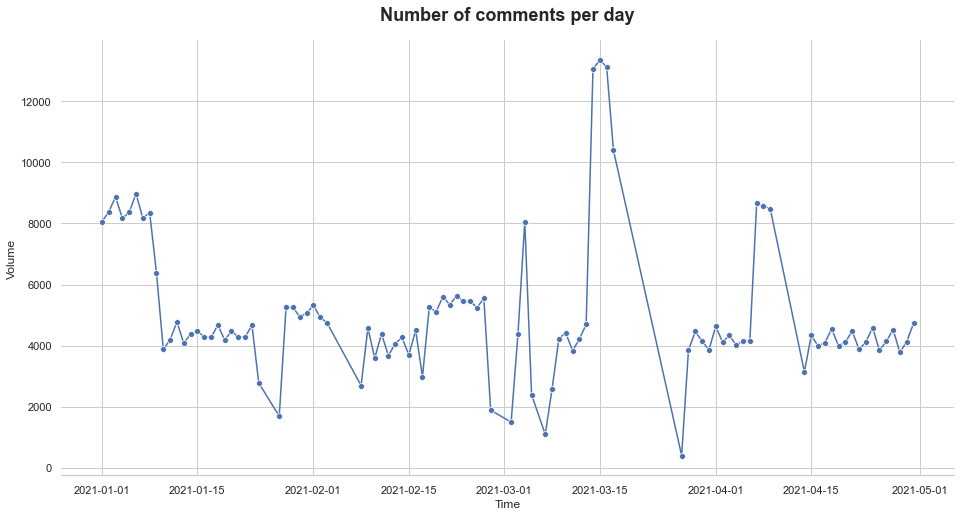

In [66]:
plt.figure(figsize=(16, 8))

sns.lineplot(x = df_copy['Date'], 
             y = df_copy['Comment Volume'], 
             data = df_copy, 
             marker = '.',
             markersize = 12)

sns.set_style('whitegrid')
sns.despine(left=True)

plt.title('Number of comments per day', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Time')
plt.ylabel('Volume')
plt.show()

In [67]:
df_copy['Comment Volume'].mean()

5030.3877551020405

In [92]:
def get_polarity(text):
    sia = SIA()
    sentiment = sia.polarity_scores(text)
    return sentiment

df['SIA'] = df['cleaned_comments'].apply(lambda x: get_polarity(x))
df.head()

,author,body,created_utc,id,Date,cleaned_comments,SIA
467541,beefywhip,"I’m sorry to tell you this, but you have a con...",1609525194,ghqp94w,2021-01-01,I’m sorry to tell you this but you have a cond...,"{'neg': 0.087, 'neu': 0.913, 'pos': 0.0, 'comp..."
465990,Aktin,same I got my masters in 2019. I thought 2020...,1609480758,ghoix2r,2021-01-01,same I got my masters in I thought would be t...,"{'neg': 0.14, 'neu': 0.86, 'pos': 0.0, 'compou..."
465989,Hubers57,I'm so fucking glad I made it to adulthood wit...,1609480758,ghoix2u,2021-01-01,Im so fucking glad I made it to adulthood with...,"{'neg': 0.214, 'neu': 0.639, 'pos': 0.147, 'co..."
465988,SKJ_2012,I wish someone could convince me to buy LEAPS ...,1609480763,ghoixba,2021-01-01,I wish someone could convince me to buy LEAPS ...,"{'neg': 0.0, 'neu': 0.68, 'pos': 0.32, 'compou..."
465987,Big_Moe_,I work in finance at a big tech company.\n\nTh...,1609480765,ghoixfm,2021-01-01,I work in finance at a big tech company The on...,"{'neg': 0.142, 'neu': 0.858, 'pos': 0.0, 'comp..."


In [93]:
def VADER_feature_engineering(dataframe):
    
    # Creating compound column by extracting it from SIA column
    dataframe['Compound Scores']  = dataframe['SIA'].apply(lambda x: x['compound'])
    
    # Creating columns of numerical values based on Compound score
    dataframe['Negative Compound Scores']  = dataframe['Compound Scores'].apply(lambda x: x if x <= -0.05 else None)
    dataframe['Positive Compound Scores']  = dataframe['Compound Scores'].apply(lambda x: x if x >= 0.05 else None)
    
    # Creating columns of categories based on Compound score
    dataframe['Negative Classes'] = dataframe['Compound Scores'].apply(lambda x: 'Negative' if x <= -0.05 else None)
    dataframe['Neutral Classes'] = dataframe['Compound Scores'].apply(lambda x: 'Neutral' if -0.05 < x < 0.05 else None)
    dataframe['Positive Classes'] = dataframe['Compound Scores'].apply(lambda x: 'Positive' if x >= 0.05 else None)
    
    #Merging the categories into one column
    dataframe['Sentiment Category'] = dataframe['Negative Classes']
    dataframe['Sentiment Category'].fillna(dataframe['Neutral Classes'], inplace = True)
    dataframe['Sentiment Category'].fillna(dataframe['Positive Classes'], inplace = True)
    
    dataframe.drop(["Negative Classes", 
                    "Neutral Classes", 
                    "Positive Classes"], 
                    axis=1, 
                    inplace = True)
    
    return dataframe

df = VADER_feature_engineering(df)
df.head()

,author,body,created_utc,id,Date,cleaned_comments,SIA,Compound Scores,Negative Compound Scores,Positive Compound Scores,Sentiment Category
467541,beefywhip,"I’m sorry to tell you this, but you have a con...",1609525194,ghqp94w,2021-01-01,I’m sorry to tell you this but you have a cond...,"{'neg': 0.087, 'neu': 0.913, 'pos': 0.0, 'comp...",-0.0387,NaN,NaN,Neutral
465990,Aktin,same I got my masters in 2019. I thought 2020...,1609480758,ghoix2r,2021-01-01,same I got my masters in I thought would be t...,"{'neg': 0.14, 'neu': 0.86, 'pos': 0.0, 'compou...",-0.4767,-0.4767,NaN,Negative
465989,Hubers57,I'm so fucking glad I made it to adulthood wit...,1609480758,ghoix2u,2021-01-01,Im so fucking glad I made it to adulthood with...,"{'neg': 0.214, 'neu': 0.639, 'pos': 0.147, 'co...",-0.6510,-0.6510,NaN,Negative
465988,SKJ_2012,I wish someone could convince me to buy LEAPS ...,1609480763,ghoixba,2021-01-01,I wish someone could convince me to buy LEAPS ...,"{'neg': 0.0, 'neu': 0.68, 'pos': 0.32, 'compou...",0.5719,NaN,0.5719,Positive
465987,Big_Moe_,I work in finance at a big tech company.\n\nTh...,1609480765,ghoixfm,2021-01-01,I work in finance at a big tech company The on...,"{'neg': 0.142, 'neu': 0.858, 'pos': 0.0, 'comp...",-0.7269,-0.7269,NaN,Negative


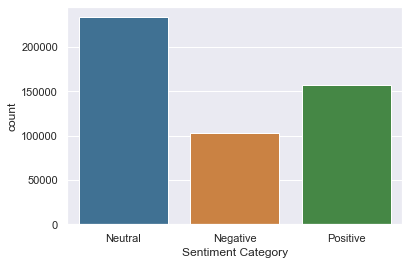

In [311]:
ax = sns.countplot(x = df["Sentiment Category"],
                   palette=['#3274a1', '#e1812c', '#3a923a'])

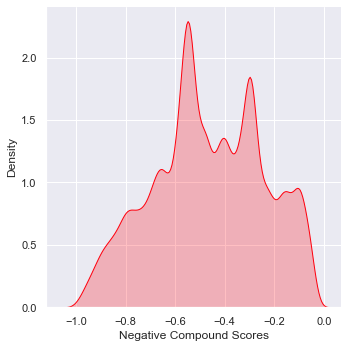

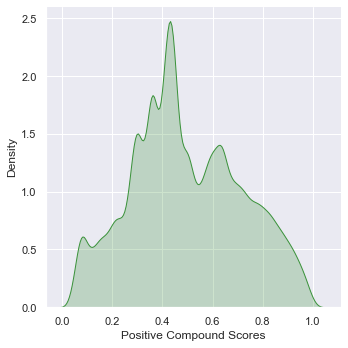

In [335]:
red = "#ff000d"
green = '#3a923a'
blue = '#3274a1'

#sns.set_style('dark')
#sns.despine(left=False)
sns.set_theme()

sns.displot(x=df["Negative Compound Scores"], 
            kind="kde", 
            fill=True, 
            color = red)

sns.displot(x=df["Positive Compound Scores"], 
            kind="kde", 
            fill=True, 
            color = green)


In [100]:
def neg_and_pos_words(dataframe):
    Negative_text = dataframe[dataframe['Negative Compound Scores'].between(-1, 0)]['cleaned_comments']
    Negative_words = ' '.join(Negative_text)
    
    Positive_text = dataframe[dataframe['Positive Compound Scores'].between(0, 1)]['cleaned_comments']
    Positive_words = ' '.join(Positive_text)
    
    return Negative_words, Positive_words

most_neg_words, most_pos_words = neg_and_pos_words(df)

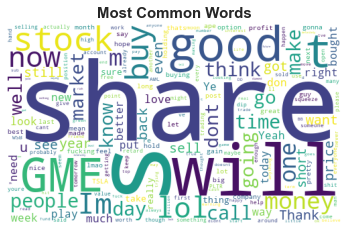

In [101]:
def word_cloud(text):
    cloud = WordCloud(width=500,
                      height=300,
                      collocations = False,
                      background_color='white').generate(text)

    plt.title('Most Common Words', fontsize=15,fontweight='bold')
    plt.imshow(cloud)
    plt.axis('off')

pos_cloud = word_cloud(most_pos_words)

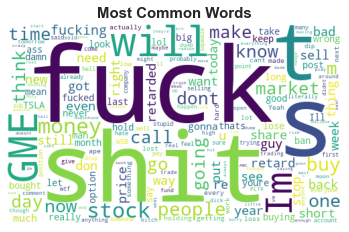

In [102]:
neg_cloud = word_cloud(most_neg_words)

In [103]:
def create_trigrams(tokens):
    trigrams = list(ngrams(tokens.split(), 4, 
                           pad_left=True, 
                           pad_right=True, 
                           ))
    trigram_count = Counter(trigrams)
    return trigram_count

positive_trigram = create_trigrams(most_pos_words)
negative_trigram = create_trigrams(most_neg_words)

common_positive = dict(collections.Counter(positive_trigram).most_common(20))
common_negative = dict(collections.Counter(negative_trigram).most_common(20))

pos_ngram_df = pd.DataFrame(list(common_positive.items()), columns=['Ngram', 'Count'])
neg_ngram_df = pd.DataFrame(list(common_negative.items()), columns=['Ngram', 'Count'])

C:\Users\Saim\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Saim\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128640 missing from current font.
  font.set_text(s, 0, flags=flags)


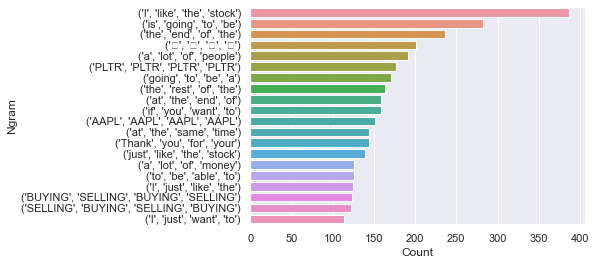

In [104]:
def horizontal_barplot(dataframe):
    sns.set(font_scale = 1)
    ax = sns.barplot(x = "Count", 
                     y = "Ngram",
                     orient = "h",
                     data = dataframe)
    return ax

pos_barplot = horizontal_barplot(pos_ngram_df)

In [105]:
df_weekly = df.copy()

resampled = df_weekly.resample('W', on='Date').mean()

resampled['Date'] = resampled.index.to_frame()
resampled.reset_index(drop = True, inplace = True)

resampled.head()

,created_utc,Compound Scores,Negative Compound Scores,Positive Compound Scores,Date
0,1.609588e+09,0.061284,-0.467281,0.496150,2021-01-03
1,1.609988e+09,0.051510,-0.463504,0.484126,2021-01-10
2,1.610622e+09,0.069962,-0.458450,0.486026,2021-01-17
3,1.611210e+09,0.063650,-0.467237,0.488536,2021-01-24
4,1.611947e+09,0.057988,-0.488929,0.516568,2021-01-31


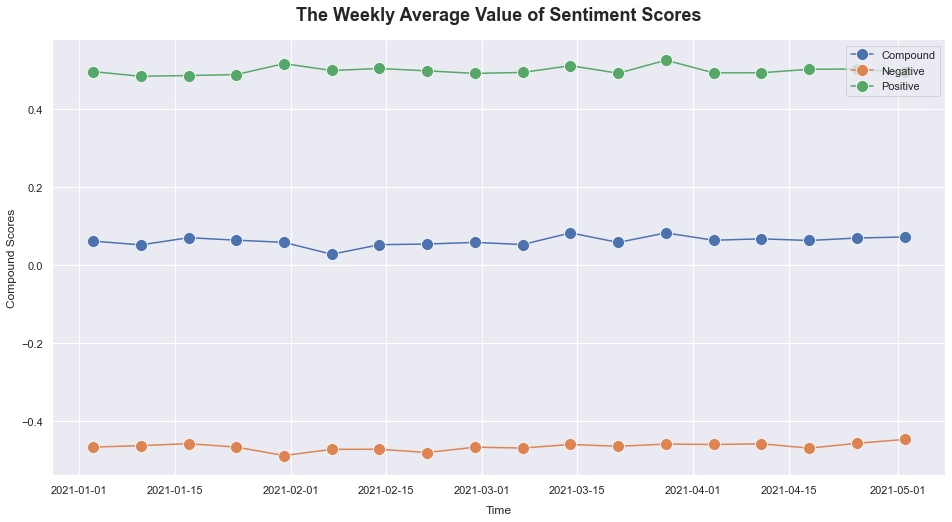

In [276]:
plt.figure(figsize=(16, 8))

sns.lineplot(x = resampled['Date'], 
             y = resampled['Compound Scores'], 
             data = resampled, 
             marker = 'o', 
             markersize = 12, 
             label = "Compound")

sns.lineplot(x = resampled['Date'], 
             y = resampled['Negative Compound Scores'], 
             data = resampled, 
             marker = 'o', 
             markersize = 12, 
             label = "Negative")

sns.lineplot(x = resampled['Date'], 
             y = resampled['Positive Compound Scores'],
             data = resampled,
             marker = 'o', 
             markersize = 12, 
             label = "Positive")

#sns.set_style('whitegrid')
sns.despine(left=False)

plt.title('The Weekly Average Value of Sentiment Scores', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Time', labelpad=10)
plt.ylabel('Compound Scores')
plt.show()

In [109]:
""""After having identified lack of accuracy in Spacy's NER we rectifiy some of the orgs"""
def ticker_replace(dataframe):
    #(?i) case insensitive
    dataframe['cleaned_comments'].replace(["(?i)gamestop", "(?i)gme"], "GME", inplace=True, regex=True)
    dataframe['cleaned_comments'].replace(["(?i)nokia", "(?i)nok"], "NOK", inplace=True, regex=True)
    dataframe['cleaned_comments'].replace(["(?i)blackberry", "(?i)bb"], "BB", inplace=True, regex=True)
    dataframe['cleaned_comments'].replace(["(?i)entertainment", "(?i)amc"], "AMC", inplace=True, regex=True)
    dataframe['cleaned_comments'].replace(["(?i)tilray", "(?i)tlry"], "TLRY", inplace=True, regex=True)
    dataframe['cleaned_comments'].replace(["(?i)tesla", "(?i)tsla"], "TSLA", inplace=True, regex=True)
    dataframe['cleaned_comments'].replace(["(?i)alibaba", "(?i)baba"], "BABA", inplace=True, regex=True)
    dataframe['cleaned_comments'].replace(["(?i)academy", "(?i)aso"], "ASO", inplace=True, regex=True)
    dataframe['cleaned_comments'].replace(["(?i)wendys", "(?i)wen"], "WEN", inplace=True, regex=True)
    dataframe['cleaned_comments'].replace(["(?i)clover", "(?i)clov"], "CLOV", inplace=True, regex=True)
    dataframe['cleaned_comments'].replace(["(?i)apple", "(?i)aapl"], "AAPL", inplace=True, regex=True)
    dataframe['cleaned_comments'].replace(["(?i)shGMEs"], "GME", inplace=True, regex=True)
    
    return dataframe

ticker_replace(df)
df.head()

,author,body,created_utc,id,Date,cleaned_comments,SIA,Compound Scores,Negative Compound Scores,Positive Compound Scores,Sentiment Category
467541,beefywhip,"I’m sorry to tell you this, but you have a con...",1609525194,ghqp94w,2021-01-01,I’m sorry to tell you this but you have a cond...,"{'neg': 0.087, 'neu': 0.913, 'pos': 0.0, 'comp...",-0.0387,NaN,NaN,Neutral
465990,Aktin,same I got my masters in 2019. I thought 2020...,1609480758,ghoix2r,2021-01-01,same I got my masters in I thought would be t...,"{'neg': 0.14, 'neu': 0.86, 'pos': 0.0, 'compou...",-0.4767,-0.4767,NaN,Negative
465989,Hubers57,I'm so fucking glad I made it to adulthood wit...,1609480758,ghoix2u,2021-01-01,Im so fucking glad I made it to adulthood with...,"{'neg': 0.214, 'neu': 0.639, 'pos': 0.147, 'co...",-0.6510,-0.6510,NaN,Negative
465988,SKJ_2012,I wish someone could convince me to buy LEAPS ...,1609480763,ghoixba,2021-01-01,I wish someone could convince me to buy LEAPS ...,"{'neg': 0.0, 'neu': 0.68, 'pos': 0.32, 'compou...",0.5719,NaN,0.5719,Positive
465987,Big_Moe_,I work in finance at a big tech company.\n\nTh...,1609480765,ghoixfm,2021-01-01,I work in finance at a big tech company The on...,"{'neg': 0.142, 'neu': 0.858, 'pos': 0.0, 'comp...",-0.7269,-0.7269,NaN,Negative


In [110]:
def train_NER(training_data):
    ner = nlp.get_pipe("ner")

    for _, annotes in training_data:
      for ent in annotes.get("entities"):
        ner.add_label(ent[2])
    
    excepted_pipes = ["ner", "trf_wordpiecer", "trf_tok2vec"]
    disabled_pipes = []

    for pipe in nlp.pipe_names:
        if pipe not in excepted_pipes:
            disabled_pipes.append(pipe)

    training_iterations = 50
    batch_sizes = compounding(4.0, 32.0, 1.001)
    # Training the model
    with nlp.disable_pipes(*disabled_pipes):
    
        for i in range(training_iterations):
        # batch up the examples using spaCy's minibatch
            mini_batches = minibatch(training_data, batch_sizes)
            for mini_batch in mini_batches:
                texts, annotes = zip(*mini_batch)
                nlp.update(texts, annotes, drop=0.2)
                          
train = [
              ("GameStop is a leading e-commerce company", {"entities": [(0, 8, "ORG")]}),
              ("I recently ordered a game from GME", {"entities": [(31,34, "ORG")]}),
              ("GME to the moon", {"entities": [(0,3, "ORG")]}),
              ("I ordered this from GME", {"entities": [(20,23, "ORG")]}),
              ("Games can be ordered from GME", {"entities": [(26,29, "ORG")]}),
              ("I bought an old game from GME", {"entities": [(26,29, "ORG")]}),
              ("GME is a rocketship", {"entities": [(0,3, "ORG")]}),
              ("GME will make me rich", {"entities": [(0,3, "ORG")]}),
              ("I love GME", {"entities": [(7,10, "ORG")]}), 
              ("Add more BB share", {"entities": [(9, 11, "ORG")]}),
              ("Without a doubt BB", {"entities": [(16,15, "ORG")]}),
              ("BB is the 2022 gme", {"entities": [(0,2, "ORG")]}),
              ("BB's revenge coming soon ??", {"entities": [(0,2, "ORG")]}),
              ("BB has rebounded nicely.", {"entities": [(0,2, "ORG")]}),
              ("BB is making me horny", {"entities": [(0,2, "ORG")]}),
              ("BB calls. any strike. any date.", {"entities": [(0,2, "ORG")]}),
              ("BB is the bomb and they have a super smart", {"entities": [(0,2, "ORG")]}),
              ("BB will go up when gme goes up because", {"entities": [(0,2, "ORG")]}),
              ("A lot of PLTR and PINS some BB and CRSR Picked all the winner", {"entities": [(28,30, "ORG")]})
              ]

train_NER(train)

In [111]:
def get_tickers(comments):
    # Spacy document object set here
    document = nlp(comments)
    ticker_list = []
    
    # .ents accesses the entities that spacy has identified
    # ORG is a subset of entities (Organizations)
    for ticker in document.ents:
        if ticker.label_ == 'ORG':
            ticker_list.append(ticker.text)
            
    output_column = list(set(ticker_list))
    return output_column

#df_test['Companies'] = df_test['cleaned_comments'].apply(get_tickers)
df['Companies'] = df['cleaned_comments'].apply(get_tickers)
df.head()

,author,body,created_utc,id,Date,cleaned_comments,SIA,Compound Scores,Negative Compound Scores,Positive Compound Scores,Sentiment Category,Companies
467541,beefywhip,"I’m sorry to tell you this, but you have a con...",1609525194,ghqp94w,2021-01-01,I’m sorry to tell you this but you have a cond...,"{'neg': 0.087, 'neu': 0.913, 'pos': 0.0, 'comp...",-0.0387,NaN,NaN,Neutral,[]
465990,Aktin,same I got my masters in 2019. I thought 2020...,1609480758,ghoix2r,2021-01-01,same I got my masters in I thought would be t...,"{'neg': 0.14, 'neu': 0.86, 'pos': 0.0, 'compou...",-0.4767,-0.4767,NaN,Negative,[]
465989,Hubers57,I'm so fucking glad I made it to adulthood wit...,1609480758,ghoix2u,2021-01-01,Im so fucking glad I made it to adulthood with...,"{'neg': 0.214, 'neu': 0.639, 'pos': 0.147, 'co...",-0.6510,-0.6510,NaN,Negative,[]
465988,SKJ_2012,I wish someone could convince me to buy LEAPS ...,1609480763,ghoixba,2021-01-01,I wish someone could convince me to buy LEAPS ...,"{'neg': 0.0, 'neu': 0.68, 'pos': 0.32, 'compou...",0.5719,NaN,0.5719,Positive,[]
465987,Big_Moe_,I work in finance at a big tech company.\n\nTh...,1609480765,ghoixfm,2021-01-01,I work in finance at a big tech company The on...,"{'neg': 0.142, 'neu': 0.858, 'pos': 0.0, 'comp...",-0.7269,-0.7269,NaN,Negative,[Google]


In [112]:
# Removes 2nd entries in the Companies column
# ['TSLA', 'AMC'] is different from ['TSLA'] by removing AMC we can count TSLA more
df.Companies.apply(lambda x: [i for i in x if i != i[1:]])

467541          []
465990          []
465989          []
465988          []
465987    [Google]
            ...   
463430          []
463431          []
463432          []
463424          []
464180        [AZ]
Name: Companies, Length: 492978, dtype: object

In [278]:
"""" Let's find the top tickers of our dataset and use them as a baseline for further EDA"""
def get_top_tickers(dataframe):
    list_ofORG = dataframe['Companies'].to_list()
    flattened = list(mit.collapse(list_ofORG))
    
    blacklist = ['%', 'SPY', 'Robinhood', '💎', 'WSB', 'RH', 
                 'Elon', 'Got', 'DFV', 'Ill', 'SEC', '🤣', 
                'Melvin', 'Fidelity', 'IV', 'Reddit', 'Biden', 
                'app', 'EV', 'BUY', 'OTM', 'guy', 'LOL', 'ITM', 
                 'DD', 'Good', 'Thank', 'US', 'There', 'Why'
                ]
    stock_list = [x for x in flattened if x not in blacklist]
    
    frequency = Counter(stock_list)
    most_commen = dict(collections.Counter(frequency).most_common(10))
    
    return most_commen

top_stocks = get_top_tickers(df)
top_stocks

{'GME': 22230,
 'TSLA': 6761,
 'AMC': 4146,
 'BB': 2841,
 'NIO': 1362,
 'AAPL': 1320,
 'NOK': 1014,
 'RKT': 1001,
 'OP': 883,
 'AMD': 820}

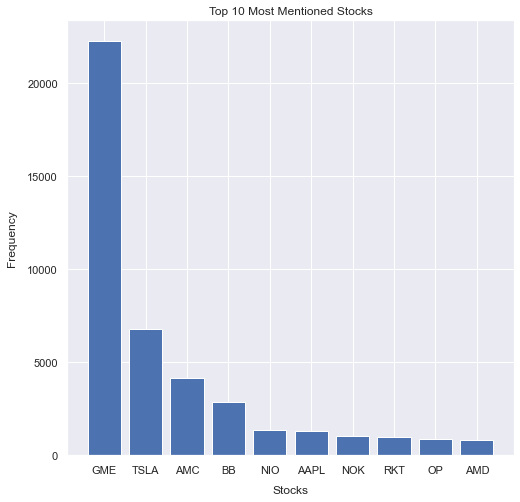

In [279]:
plt.figure(figsize=(8, 8))
labels, values = zip(*top_stocks.items())
plt.bar(labels, values)
plt.title("Top 10 Most Mentioned Stocks")
plt.xlabel('Stocks', labelpad=10)
plt.ylabel('Frequency', labelpad=10)
plt.show()

In [333]:
def top_10_df(dataframe):
    dataframe['Top Companies'] = dataframe['Companies'].apply(' '.join)
    df = dataframe[dataframe['Top Companies'].isin(['GME', 
                                                    'TSLA', 
                                                    'AMC', 
                                                    'BB', 
                                                    'NIO', 
                                                    'AAPL', 
                                                    'NOK', 
                                                    'RKT', 
                                                    'OP', 
                                                    'AMD'])]
    ones = [1 for x in range(len(df.index))]
    df["Count"] = ones
    df['Comment Volume'] = df['Count'].groupby(df['Top Companies']).transform('sum')
    

    return df

top_stocks = df.copy()
top_stocks = top_10_df(top_stocks)

<ipython-input-333-8343a5e93ab3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Count"] = ones
<ipython-input-333-8343a5e93ab3>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Comment Volume'] = df['Count'].groupby(df['Top Companies']).transform('sum')


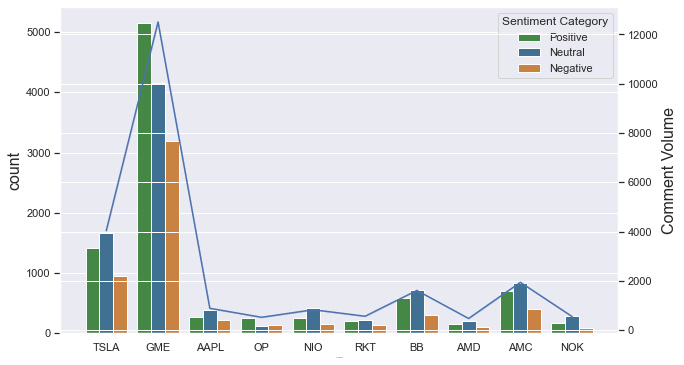

In [342]:
#Create combo chart
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.set_title('', fontsize=16)
ax1.set_xlabel('Companies', fontsize=0.01)
ax1.set_ylabel('Sentiment', fontsize=16)
ax1 = sns.countplot(x='Top Companies', 
                    hue='Sentiment Category',
                    data = top_stocks, 
                    palette=['#3a923a', '#3274a1', '#e1812c'])
ax1.tick_params(axis='y') 

ax2 = ax1.twinx()

ax2.set_ylabel('Comment Volume', fontsize=16)
ax2 = sns.lineplot(x='Top Companies', 
                   y='Comment Volume', 
                   data = top_stocks, 
                   sort=False)
ax2.tick_params(axis='y')

In [140]:
def get_yfinance(ticker_name: str):
    
    # Initialize stock object and get a dataframe of its info
    stock = yf.Ticker(ticker_name)
    hist = stock.history(start = "2021-01-01", end = "2021-05-01")
    
    hist.drop(['High', 
                'Low',
                'Dividends',
                'Stock Splits'], 
               axis=1, 
               inplace = True)
    
    #Dates belong the index and so is set to a column here. Format is changed to day/month/year
    hist['Date'] = hist.index.to_frame()
    hist.reset_index(drop = True, inplace = True)

    
    stock_df = hist.rename(columns={'Date': 'Ticker Date'})
    return stock_df

gme = get_yfinance("GME")
amc = get_yfinance("AMC")
tsla= get_yfinance("TSLA")

In [297]:
# Subsets dataframe based on passed stock
def stock_subset(dataframe, stock: str):
    print(dataframe['Date'].nunique())
    
    # Subsets dataframe based on stock
    subset = dataframe[dataframe['Companies'].apply(lambda x: x[0] if len(x) > 0 else np.nan) == stock]
    # Aggregates compund scores for each date
    subset['Compound Sum'] = dataframe['Compound Scores'].groupby(dataframe['Date']).transform('sum')
    # Deletes duplicates
    subset.drop_duplicates(subset = "Date", 
                                keep = "first", 
                                inplace = True)
    print(subset['Date'].nunique())
    
    return subset

gme_df = stock_subset(df, "GME")
amc_df = stock_subset(df, "AMC")
tsla_df= stock_subset(df, "TSLA")

98


<ipython-input-297-fb8bacfb5742>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Compound Sum'] = dataframe['Compound Scores'].groupby(dataframe['Date']).transform('sum')
<ipython-input-297-fb8bacfb5742>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.drop_duplicates(subset = "Date",


98
98
90
98
96


In [298]:
# merges stock subset df with stock price df
def merge(stock_subset_df, stock_price_df):
    df_merg = stock_subset_df.merge(stock_price_df, left_on='Date', right_on='Ticker Date')

    return df_merg

gme_full = merge(gme_df, gme)
amc_full = merge(amc_df, amc)
tsla_full= merge(tsla_df, tsla)

In [299]:
def weekly_stock_price(dataframe):

    gme_resampled = dataframe.resample('W', on='Date').mean()
    gme_resampled['Date'] = gme_resampled.index.to_frame()
    gme_resampled.reset_index(drop = True, inplace = True)
    
    return gme_resampled
    
gme_weekly = weekly_stock_price(gme_full)
amc_weekly = weekly_stock_price(amc_full)
tsla_weekly= weekly_stock_price(tsla_full)

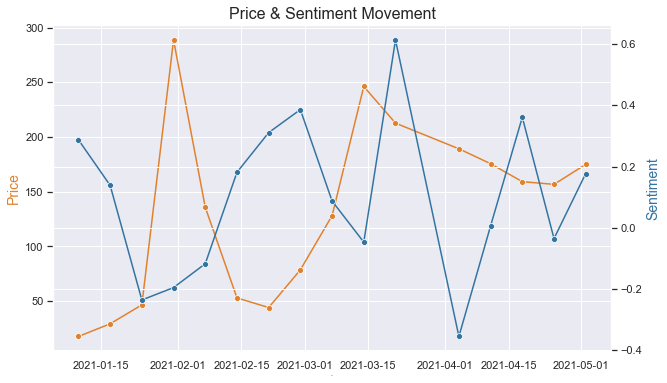

In [319]:
def price_sentiment(dataframe):
    fig, ax1 = plt.subplots(figsize=(10,6))

    #Set design
    ax1.set_title('Price & Sentiment Movement', fontsize=16)
    ax1.set_xlabel('Time', fontsize=0.01)
    ax1.set_ylabel('Price', fontsize=14, color = '#e1812c')

    ax1 = sns.lineplot(x ='Date', 
                       y = 'Close', 
                       data = dataframe, 
                       marker = "o",
                       color = '#e1812c')
    ax1.tick_params(axis = 'y')
    #specify we want to share the same x-axis
    ax2 = ax1.twinx()


    #palette=['#e1812c', '#3274a1', '#3a923a']
    ax2.set_ylabel('Sentiment', fontsize=14, color = '#3274a1')
    ax2 = sns.lineplot(x='Date', 
                       y='Compound Scores', 
                       data = dataframe, 
                       sort=False,
                       marker = "o",
                       color = '#3274a1')
    ax2.tick_params(axis='y')
    
    plt.show()
    
price_sentiment(gme_weekly)

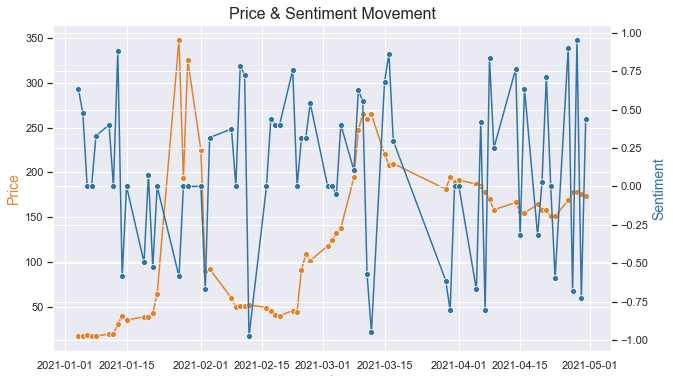

In [320]:
price_sentiment(gme_full)

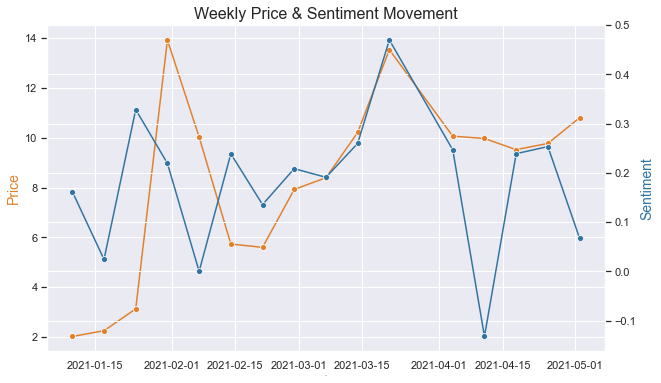

In [300]:
price_sentiment(amc_weekly)

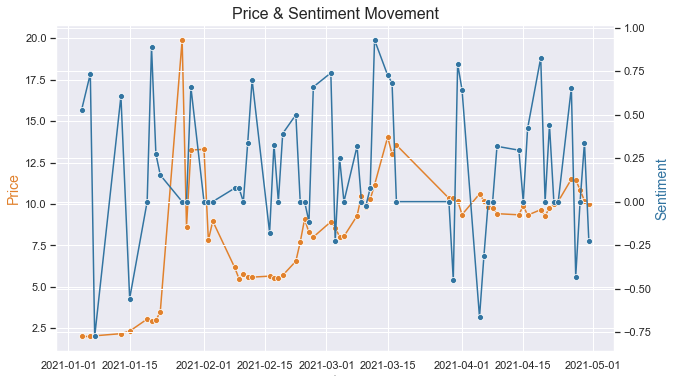

In [321]:
price_sentiment(amc_full)

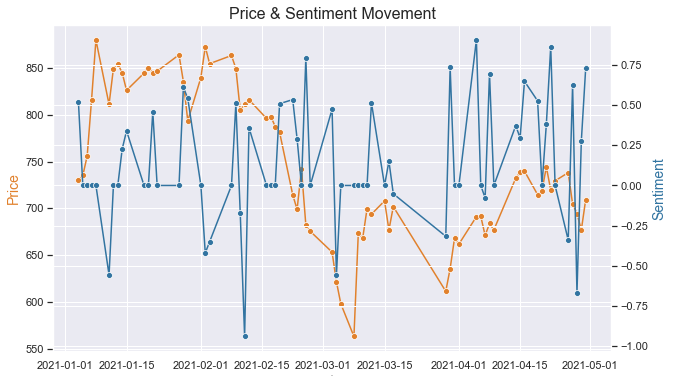

In [322]:
price_sentiment(tsla_full)

(-0.157632086295453, 0.19920792737190202)


<AxesSubplot:xlabel='Compound Scores', ylabel='Price'>

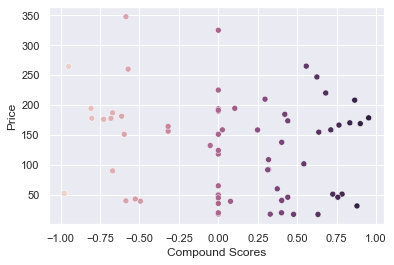

In [346]:
def scatterplot(dataframe):

    scatter = sns.scatterplot(data=dataframe, x="Compound Scores", y="Close", hue = "Compound Scores")
    scatter.legend_.remove()
    plt.ylabel('Price')
    
    #correlation coeff and p-value
    print(stats.pearsonr(dataframe['Compound Scores'], dataframe['Close']))
    
    return scatter

scatterplot(gme_full)

(-0.009292839819847173, 0.9423757961837709)


<AxesSubplot:xlabel='Compound Scores', ylabel='Price'>

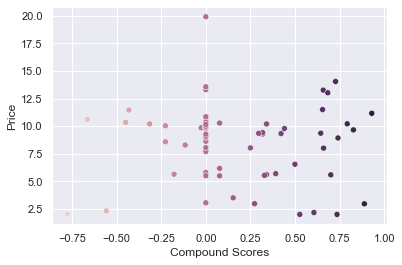

In [326]:
scatterplot(amc_full)

(-0.12271650061705845, 0.3225065095279521)


<AxesSubplot:xlabel='Compound Scores', ylabel='Price'>

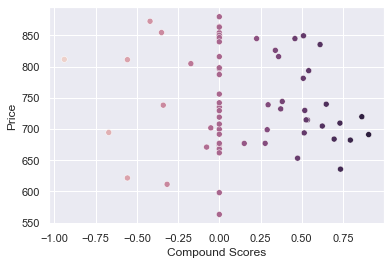

In [327]:
scatterplot(tsla_full)